In [281]:
# Kaggle runs 0.21, which has a bug
#!pip install scikit-learn==0.20.3

In [282]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [283]:
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn as skl
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, Lasso, LinearRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import lightgbm as lgb

from xgboost import XGBClassifier, XGBRegressor

from scipy import stats
from scipy.special import boxcox1p

%matplotlib inline

In [284]:
trainCsvFilepath = r'../input/forest-cover-type-prediction/train.csv'
train = pd.read_csv(trainCsvFilepath)

testCsvFilepath = r'../input/forest-cover-type-prediction/test.csv'
test = pd.read_csv(testCsvFilepath)
testIds = test.Id.copy()

In [285]:
merged = pd.concat([train, test], axis=0, sort=False)

# NULL Values

# Feature Engineer

## Distance from hori and vert distances

In [286]:
temp = merged.copy()

#temp.drop(columns=['Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology'], inplace=True)

temp['Distanse_to_Hydrolody'] = (temp['Horizontal_Distance_To_Hydrology']**2+temp['Vertical_Distance_To_Hydrology']**2)**0.5
     
temp['Hydro_plus_Fire'] = temp['Horizontal_Distance_To_Hydrology']+temp['Horizontal_Distance_To_Fire_Points']
     
temp['Hydro_minus_Fire'] = temp['Horizontal_Distance_To_Hydrology']-temp['Horizontal_Distance_To_Fire_Points']
     
temp['Hydro_plus_Road'] = temp['Horizontal_Distance_To_Hydrology']+temp['Horizontal_Distance_To_Roadways']
     
temp['Hydro_minus_Road'] = temp['Horizontal_Distance_To_Hydrology']-temp['Horizontal_Distance_To_Roadways']
     
temp['Fire_plus_Road'] = temp['Horizontal_Distance_To_Fire_Points']+temp['Horizontal_Distance_To_Roadways']
     
temp['Fire_minus_Road'] = temp['Horizontal_Distance_To_Fire_Points']-temp['Horizontal_Distance_To_Roadways']

merged = temp

# Transform data

# Encoding

# Drop

In [287]:
merged.drop(columns=['Soil_Type7', 'Soil_Type15', 'Id'], inplace=True)

# Train and test

In [288]:
train = merged.iloc[:train.shape[0], :]
train;

In [289]:
test = merged.iloc[train.shape[0]:, :]
test;

In [290]:
xTrain = train.drop(columns=['Cover_Type'])
yTrain = train.loc[:, 'Cover_Type'].astype(int)

In [291]:
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, random_state=42, test_size=0.2)

In [292]:
xTest = test.drop(columns=['Cover_Type'])

## Train on a portion of data to reduce time

# Scale

scaleFeats = True
if scaleFeats:
    scaler = StandardScaler()
    xTrain = scaler.fit_transform(xTrain)
    xTest = scaler.transform(xTest)

# Dimensionality reduction

performPCA = False

if performPCA:
    pca = PCA(n_components=10, random_state=42)
    pca.fit(xTrain)
    
    print(pca.explained_variance_ratio_)
    
    xTrain = pca.transform(xTrain)
    xTest = pca.transform(xTest)

# Model

In [293]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

## XGB

xgb = XGBClassifier(random_state=42, n_jobs=-1, objective='multi:softmax', num_class=len(train.Cover_Type.unique()))

fullPipeline = Pipeline(steps=[
    #('featureEngPipeline', featureEngPipeline),
    #('transformPipeline', transformPipeline),
    ('scaler', StandardScaler()),
    ('model', xgb)
])

xgb_param_space = {  
    "model__n_estimators": Integer(40, 200),
    "model__max_depth": Integer(10, 50),
    "model__learning_rate": Real(0.05, 0.4),
    #"colsample_bytree": one_to_left,
    #"model__subsample": one_to_left,
    #"model__gamma": stats.uniform(0, 10),
    #'model__reg_alpha': from_zero_positive,
    "model__min_child_weight": Integer(1, 7),
}

BSXGB = BayesSearchCV(fullPipeline, xgb_param_space, scoring='accuracy', random_state=42, n_jobs=-1, cv=5, n_iter=40, verbose=3)
%time BSXGB.fit(subX.astype(float), subY)

print(BSXGB.best_params_)
cv_results_df = pd.DataFrame(BSXGB.cv_results_)
print(cv_results_df.mean_test_score.max())

## LGBM

In [343]:
lg = lgb.LGBMClassifier(random_state=42, n_jobs=-1, objective='multiclass', n_estimators=5000)

fullPipeline = Pipeline(steps=[
    #('featureEngPipeline', featureEngPipeline),
    #('transformPipeline', transformPipeline),
    ('scaler', StandardScaler()),
    ('model', lg)
])

param_dis = {
    'model__max_depth': stats.randint(25, 76),
    'model__learning_rate': stats.uniform(0.01, 0.1),
    'model__num_leaves': stats.randint(300, 1201),
    'model__n_estimator': [200]
}

RSLGB = RandomizedSearchCV(fullPipeline, param_dis, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1, cv=5, iid=False)
RSLGB.fit()

param_grid = {
    'model__max_depth': [25,50, 75],
    'model__learning_rate': [0.01,0.05,0.1],
    'model__num_leaves': [300,900,1200],
    'model__n_estimators': [200]
}

GSLGB = GridSearchCV(fullPipeline, param_grid, scoring='accuracy', n_jobs=-1, cv=5, iid=False)
GSLGB_scores = cross_val_score(GSLGB, xTrain, yTrain, scoring='accuracy', cv=5);
GSLGB_scores.mean()

In [355]:
param_space =  {'model__max_depth': [2, 63],
    #'model__learning_rate': [0.01,0.5],
    'model__num_leaves': [7, 4095],
    #'model__n_estimators': 5000
}

fit_params = {
    'model__early_stopping_rounds':30,
    'model__eval_metric':'multi_logloss',
    'model__eval_set':[(xValid, yValid)],
}

BSLGB = BayesSearchCV(fullPipeline, param_space, random_state=42, scoring='accuracy', cv=5, n_iter=50, verbose=3, n_jobs=-1, 
                      fit_params=fit_params)
%time BSLGB.fit(xTrain.astype(float), yTrain)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.5s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.6s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.4s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.3s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.6s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.9s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.2s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.5s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.0s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.4s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.0s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.5s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.0s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.9s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.3s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.9s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.2s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.6s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.8s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


Wall time: 10min 4s


BayesSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=...   reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0))]),
       fit_params={'model__early_stopping_rounds': 30, 'model__eval_metric': 'multi_logloss', 'model__eval_set': [(      Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0          2432     147     16                                90
1          2653     114     14                          ...603    1
13692    6
2347     5
12421    4
3601     4
Name: Cover_Type, Length: 3024, dtype: int32)]},
       iid=True, n_iter=50, n_jobs=-1, n_points=1, optimizer_kwargs=None,
       pre_dispatch='2*n_j

In [365]:
print(BSLGB.best_params_)
print(BSLGB.best_estimator_.named_steps['model'].get_params())
cv_results_df = pd.DataFrame(BSLGB.cv_results_)
print(cv_results_df.mean_test_score.max())

{'model__max_depth': 23, 'model__num_leaves': 2088}
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 23, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 5000, 'n_jobs': -1, 'num_leaves': 2088, 'objective': 'multiclass', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
0.8287037037037037


In [361]:
dir(BSLGB.best_estimator_.named_steps['model'])
BSLGB.best_estimator_.named_steps['model'].get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=23,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=5000, n_jobs=-1, num_leaves=2088,
        objective='multiclass', random_state=42, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)>

## SVM

svm = SVC(kernel='linear')
cross_val_score(svm, xTrain, yTrain, cv=3, n_jobs=-1, scoring='accuracy').mean()

## Notes

v1: LGBM
{'model__learning_rate': 0.04183987669962862, 'model__max_depth': 5, 'model__n_estimators': 50, 'model__num_leaves': 300}
0.5788359788359788

v2: LGBM, dist = vert combined hor
{'model__learning_rate': 0.03299957817113456, 'model__max_depth': 5, 'model__n_estimators': 50, 'model__num_leaves': 300}
0.5777777777777777

v3: LGBM, change search space
{'model__learning_rate': 0.08180887946437668, 'model__max_depth': 3, 'model__n_estimators': 10, 'model__num_leaves': 600}
0.5858465608465608

v4: expand search space
{'model__learning_rate': 0.3062032812939179, 'model__max_depth': 20, 'model__n_estimators': 600, 'model__num_leaves': 900}
0.8792162698412699

v5: folow: https://github.com/microsoft/LightGBM/issues/872
{'model__max_depth': 23, 'model__num_leaves': 2088}
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 23, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 5000, 'n_jobs': -1, 'num_leaves': 2088, 'objective': 'multiclass', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
0.8287037037037037

# Confusion Matrix

In [367]:
model = BSLGB.best_estimator_

In [368]:
#model.fit(localXTrain.astype(float), localyTrain.astype(int));

In [369]:
yValid_pred = model.predict(xValid)
print(accuracy_score(yValid, yValid_pred))
confusionMatrix = confusion_matrix(yValid, yValid_pred)

C:\Anaconda3x64\envs\ml\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9007936507936508


Normalized confusion matrix
Confusion matrix, without normalization


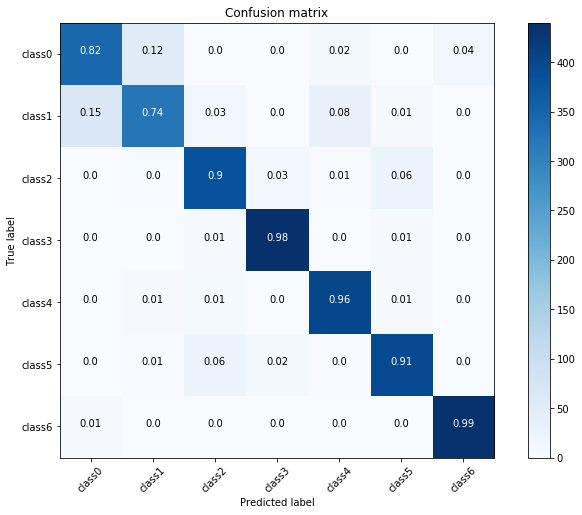

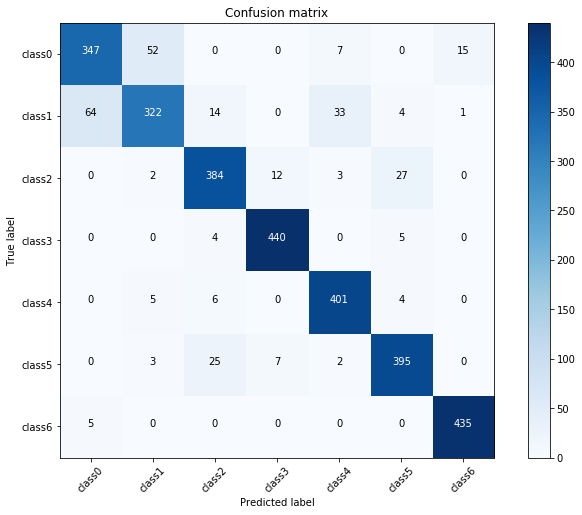

In [370]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusionMatrix, ['class' + str(x) for x in range(0, len(train.Cover_Type.unique()))]
                     , True)
plot_confusion_matrix(confusionMatrix, ['class' + str(x) for x in range(0, len(train.Cover_Type.unique()))]
                     , False)

# Improve class 1 and 2 prediction

trainData = pd.concat([xTrain, yTrain], axis=1)
trainData12 = trainData[trainData.Cover_Type.isin([1, 2])].copy()
trainX12, trainY12 = trainData12.drop(columns=['Cover_Type']), trainData12['Cover_Type']

trainX12.describe()

# Remove columns with std=0 in trainX12
stds12 = trainX12.std()
columnsWithStdZero12 = stds12[stds12 == 0].index
print(columnsWithStdZero12)
trainX12.drop(columns=columnsWithStdZero12, inplace=True)

lg12 = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

fullPipeline12 = Pipeline(steps=[
    #('featureEngPipeline', featureEngPipeline),
    #('transformPipeline', transformPipeline),
    ('scaler', StandardScaler()),
    ('model', lg12)
])

param_space =  {'model__max_depth': [3,20],
    'model__learning_rate': [0.01,0.1],
    'model__num_leaves': [100,900],
    'model__n_estimators': [10, 300]
}

BSLGB12 = BayesSearchCV(fullPipeline12, param_space, random_state=42, scoring='accuracy', cv=5, n_iter=40, verbose=3, n_jobs=-1)
%time BSLGB12.fit(trainX12.astype(float), trainY12)

print(BSLGB12.best_params_)
cv_results_df12 = pd.DataFrame(BSLGB12.cv_results_)
print(cv_results_df12.mean_test_score.max())

validData = pd.concat([xValid, yValid], axis=1)
validData12 = validData[validData.Cover_Type.isin([1, 2])].copy()
validX12, validY12 = validData12.drop(columns=['Cover_Type']), validData12['Cover_Type']

validX12.drop(columns=['Soil_Type1', 'Soil_Type5', 'Soil_Type14', 'Soil_Type37'], inplace=True)

model12 = BSLGB12.best_estimator_
validPreds12 = model12.predict(validX12)

confusionMatrix12 = confusion_matrix(validY12, validPreds12)
plot_confusion_matrix(confusionMatrix12, ['class' + str(x) for x in range(1, 3)], True)
accuracy_score(validY12, validPreds12)

# Use model12 to enhance main model performance on class 1 and 2

#yValid_pred = model.predict(xValid)
#print(accuracy_score(yValid, yValid_pred))
#confusionMatrix = confusion_matrix(yValid, yValid_pred)
xValid = xValid.reset_index(drop=True)
yValid_pred_df = pd.DataFrame(data=yValid_pred, columns=['preds'])
indexesPreds12 = yValid_pred_df[yValid_pred_df.preds.isin([1, 2])].index
xValid12 = xValid.iloc[indexesPreds12]

predsValid12 = model12.predict(xValid12)
predsValid12Df = pd.DataFrame(data=predsValid12, index=indexesPreds12)

yValid_pred_df.iloc[predsValid12Df.index, 0] = predsValid12Df.iloc[:,0]

confusionMatrixCombined = confusion_matrix(yValid, yValid_pred_df)
plot_confusion_matrix(confusionMatrixCombined, ['class' + str(x) for x in range(1, 8)], True)
accuracy_score(yValid, yValid_pred_df)

sns.barplot(y=model.named_steps['model'].feature_importances_, x=[x for x in range(len(model.named_steps['model'].feature_importances_))])

plt.figure(figsize=(30, 20))

sns.barplot(y=model12.named_steps['model'].feature_importances_, x=trainX12.columns)
plt.xticks(rotation=90)


trainX12.columns

# Submission

In [315]:
model = BSLGB.best_estimator_

In [316]:
#%time model.fit(xTrain.astype(float), yTrain)

In [317]:
pred = model.predict(xTest)

C:\Anaconda3x64\envs\ml\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [318]:
output=pd.DataFrame({'Id':testIds,'Cover_Type':pred})

In [319]:
output.to_csv('submission.csv', index=False)

In [320]:
output.head()

,Id,Cover_Type
0,15121,2
1,15122,2
2,15123,2
3,15124,2
4,15125,2
